In [ ]:
import cv2 

img = cv2.imread('/home/likcos/DataSets/sportimages/sportimages/basket/basket2_0001.jpg')
print(img.shape[0], img.shape[1], img.shape[2], len(img.shape))

# Convolutional Neural Networks

# Importar Librerías

In [37]:
import cv2 
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [38]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.layers import LeakyReLU
import h5py

# Cargar set de Imágenes

In [39]:
dirname = os.path.join(os.getcwd(),'C:\\Users\\Edani\\Downloads\\DatasetCNN')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            if(len(image.shape)==3):
                
                images.append(image)
            else:{
                print("La imagen: " + filename + "en el directorio: " + root)
            }
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))
print('imagenes:',len(images))

leyendo imagenes de  C:\Users\Edani\Downloads\DatasetCNN\
C:\Users\Edani\Downloads\DatasetCNN\floripondio 1
C:\Users\Edani\Downloads\DatasetCNN\f_margarita 5617
C:\Users\Edani\Downloads\DatasetCNN\girasol 5337
C:\Users\Edani\Downloads\DatasetCNN\nochebuena 4269
C:\Users\Edani\Downloads\DatasetCNN\rosa 4269
Directorios leidos: 5
Imagenes en cada directorio [5618, 5337, 4269, 4269, 4268]
suma Total de imagenes en subdirs: 23761
imagenes: 23761


# Creamos las etiquetas

In [40]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  23761


In [41]:
flores=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    flores.append(name[len(name)-1])
    indice=indice+1

0 floripondio
1 f_margarita
2 girasol
3 nochebuena
4 rosa


In [6]:
# Supongamos que todas las imágenes deben tener la misma forma (por ejemplo, 100x100 píxeles)
target_shape = (28, 21)
 
# Asegúrate de que todas las imágenes tengan la misma forma
images = [cv2.resize(img, target_shape) for img in images]
print(len(images))
 
# Ahora convierte la lista en un array NumPy
X = np.array(images, dtype=np.uint8)
y = np.array(labels)

 
# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

23761
Total number of outputs :  5
Output classes :  [0 1 2 3 4]


# Creamos Sets de Entrenamiento y Test

In [7]:
print(len(X), len(y))
train_X,test_X,train_Y,test_Y=train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

23761 23761
Training data shape :  (19008, 21, 28, 3) (19008,)
Testing data shape :  (4753, 21, 28, 3) (4753,)


Text(0.5, 1.0, 'Ground Truth : 4')

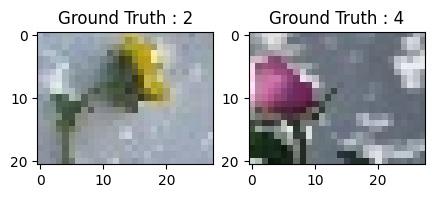

In [8]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

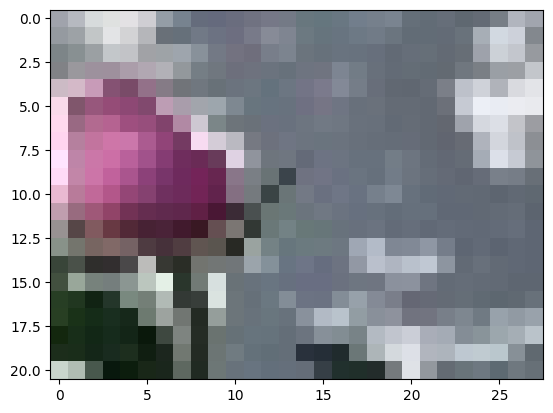

In [9]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [10]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 2
After conversion to one-hot: [0. 0. 1. 0. 0.]


# Creamos el Set de Entrenamiento y Validación

In [11]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [12]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(15206, 21, 28, 3) (3802, 21, 28, 3) (15206, 5) (3802, 5)


# Creamos el modelo de CNN

In [13]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 50 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 32 # cantidad de imágenes que se toman a la vez en memoria

In [14]:
CNNDefinitiva_model = Sequential()
CNNDefinitiva_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
CNNDefinitiva_model.add(LeakyReLU(alpha=0.1))
CNNDefinitiva_model.add(MaxPooling2D((2, 2),padding='same'))
CNNDefinitiva_model.add(Dropout(0.5))

CNNDefinitiva_model.add(Flatten())
CNNDefinitiva_model.add(Dense(32, activation='linear'))
CNNDefinitiva_model.add(LeakyReLU(alpha=0.1))
CNNDefinitiva_model.add(Dropout(0.5))
CNNDefinitiva_model.add(Dense(nClasses, activation='softmax'))

In [15]:
CNNDefinitiva_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 28, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 21, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 11, 14, 32)        0         
                                                                 
 flatten (Flatten)           (None, 4928)              0         
                                                                 
 dense (Dense)               (None, 32)                157728    
                                                        

In [16]:
CNNDefinitiva_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

In [141]:
tf.config.experimental_run_functions_eagerly(True)

# Entrenamos el modelo: Aprende a clasificar imágenes

In [17]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
CNNDefinitiva_train = CNNDefinitiva_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/50


476/476 [==============================] - 2s 4ms/step - loss: 1.6008 - accuracy: 0.2557 - val_loss: 1.5578 - val_accuracy: 0.3485
Epoch 2/50
476/476 [==============================] - 2s 4ms/step - loss: 1.5573 - accuracy: 0.3120 - val_loss: 1.5031 - val_accuracy: 0.5421
Epoch 3/50
476/476 [==============================] - 2s 4ms/step - loss: 1.5012 - accuracy: 0.3681 - val_loss: 1.3834 - val_accuracy: 0.6765
Epoch 4/50
476/476 [==============================] - 2s 4ms/step - loss: 1.4048 - accuracy: 0.4396 - val_loss: 1.2590 - val_accuracy: 0.7086
Epoch 5/50
476/476 [==============================] - 2s 4ms/step - loss: 1.3197 - accuracy: 0.4828 - val_loss: 1.1417 - val_accuracy: 0.7246
Epoch 6/50
476/476 [==============================] - 2s 4ms/step - loss: 1.2149 - accuracy: 0.5420 - val_loss: 1.0294 - val_accuracy: 0.7538
Epoch 7/50
476/476 [==============================] - 2s 4ms/step - loss: 1.1342 - accuracy: 0.5795 - val_loss: 0.9424 - val_accuracy: 0.7517
Epoc

In [18]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
CNNDefinitiva_model.save('C:\\xampp\\htdocs\\phaser\\ProyectoFlores\\CNNDefinitiva.h5py')

INFO:tensorflow:Assets written to: C:\xampp\htdocs\phaser\ProyectoFlores\CNNDefinitiva.h5py\assets


INFO:tensorflow:Assets written to: C:\xampp\htdocs\phaser\ProyectoFlores\CNNDefinitiva.h5py\assets


# Evaluamos la red

In [19]:
test_eval = CNNDefinitiva_model.evaluate(test_X, test_Y_one_hot, verbose=1)

149/149 [==============================] - 0s 1ms/step - loss: 0.2959 - accuracy: 0.9354


In [20]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.2959039807319641
Test accuracy: 0.9354091882705688


In [21]:
CNNDefinitiva_train.history

{'loss': [1.600832223892212,
  1.5572574138641357,
  1.501171588897705,
  1.4047778844833374,
  1.3196918964385986,
  1.2148517370224,
  1.1341710090637207,
  1.0608285665512085,
  1.0044128894805908,
  0.9551801681518555,
  0.912885308265686,
  0.8772831559181213,
  0.8380162715911865,
  0.8148045539855957,
  0.7941564917564392,
  0.7656314373016357,
  0.7386754751205444,
  0.7263484597206116,
  0.70736163854599,
  0.691529393196106,
  0.6756658554077148,
  0.6484216451644897,
  0.6391263604164124,
  0.6266488432884216,
  0.6152442693710327,
  0.600618839263916,
  0.5863929390907288,
  0.572781503200531,
  0.5688584446907043,
  0.5624971389770508,
  0.5443716645240784,
  0.5300537943840027,
  0.5288845896720886,
  0.5129047632217407,
  0.5122950077056885,
  0.5000349879264832,
  0.49625349044799805,
  0.48444026708602905,
  0.4811214804649353,
  0.47290945053100586,
  0.4712578058242798,
  0.4622184634208679,
  0.46170228719711304,
  0.4535987973213196,
  0.44645532965660095,
  0.4478

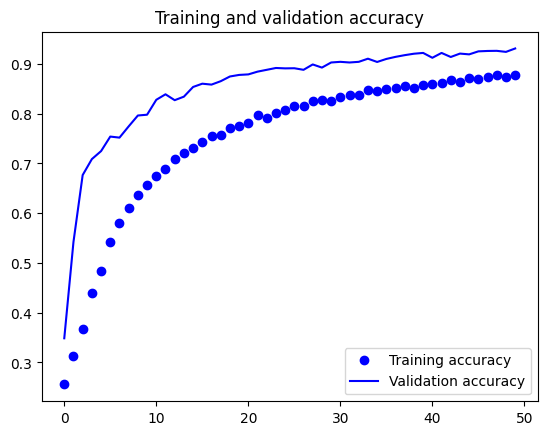

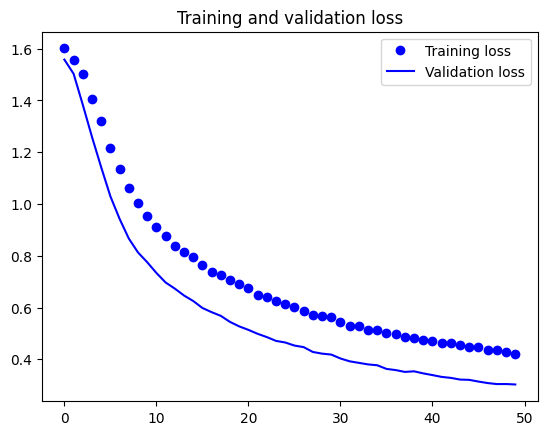

In [22]:
accuracy = CNNDefinitiva_train.history['accuracy']
val_accuracy = CNNDefinitiva_train.history['val_accuracy']
loss = CNNDefinitiva_train.history['loss']
val_loss = CNNDefinitiva_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
predicted_classes2 = CNNDefinitiva_model.predict(test_X)

149/149 [==============================] - 0s 1ms/step


In [24]:
predicted_classes=[]
for predicted_flores in predicted_classes2:
    predicted_classes.append(predicted_flores.tolist().index(max(predicted_flores)))
predicted_classes=np.array(predicted_classes)

In [25]:
predicted_classes.shape, test_Y.shape

((4753,), (4753,))

# Aprendamos de los errores: Qué mejorar

Found 4446 correct labels


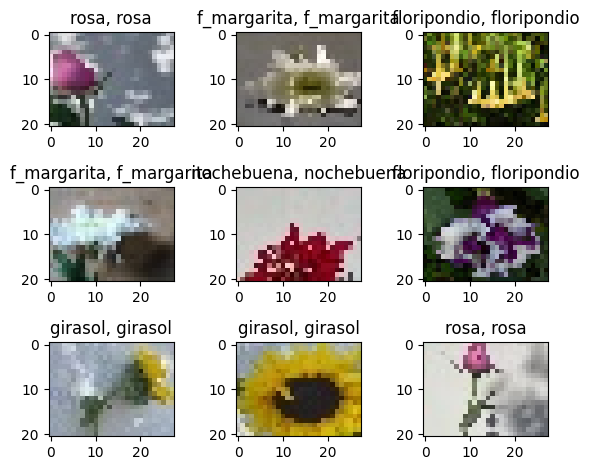

In [26]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(flores[predicted_classes[correct]],
                                                    flores[test_Y[correct]]))

    plt.tight_layout()

Found 307 incorrect labels


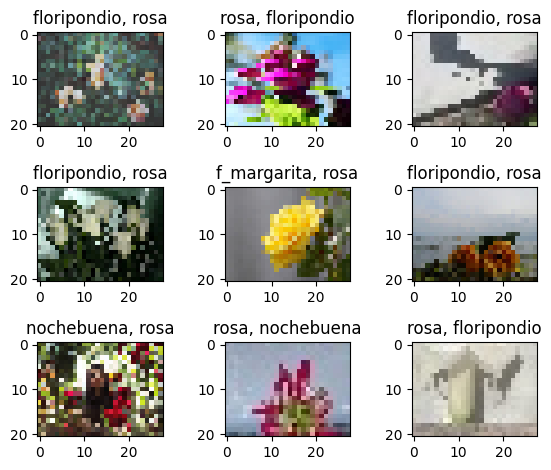

In [27]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(flores[predicted_classes[incorrect]],
                                                    flores[test_Y[incorrect]]))
    plt.tight_layout()

In [28]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.91      0.93      0.92      1105
     Class 1       0.96      0.98      0.97      1076
     Class 2       0.97      0.93      0.95       848
     Class 3       0.89      0.98      0.94       841
     Class 4       0.94      0.85      0.89       883

    accuracy                           0.94      4753
   macro avg       0.94      0.93      0.93      4753
weighted avg       0.94      0.94      0.94      4753



# PROBANDO LA RED CONVOLUSIONAL

1/1 [==============================] - 0s 60ms/step


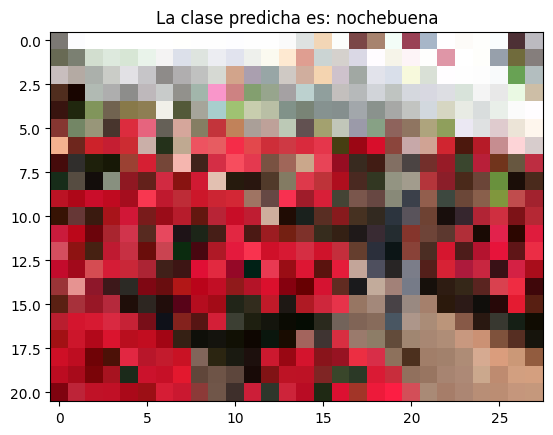

In [51]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
# Cargar el modelo desde el archivo HDF5
CNNDefinitiva_model = load_model('C:\\xampp\\htdocs\\phaser\\ProyectoFlores\\CNNDefinitiva.h5py')
# Cargar la imagen con OpenCV
img = cv2.imread('C:\\Users\\Edani\\Downloads\\PruebaVideo\\.jpg')
img = cv2.resize(img, (28, 21))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array = img_array.astype('float32')
img_array = img_array / 255.

# Realizar la predicción
predicted_class = CNNDefinitiva_model.predict(img_array)
clase_predicha = np.argmax(predicted_class)

# Obtener el nombre de la clase predicha (asumiendo que tienes un diccionario class_names) # Reemplaza con tu diccionario
nombre_clase_predicha = flores[clase_predicha]

# Mostrar la imagen con el nombre de la clase predicha
plt.imshow(img_array[0, :, :])
plt.title("La clase predicha es: "+ nombre_clase_predicha, fontsize=12)
plt.show()